In [1]:
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, SpatialDropout1D,Bidirectional
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

C:\Users\Tanvir\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df = pd.read_csv("dataprep.csv")  
df['Label'] = df.Label.map({'H':0, 'N':1})
df.head()

Label                                          Statement
0      0  @Grumpy_P_Sloth @deanesmay feminists argue for...
1      0  1948Army of England helped the Jews to occupy ...
2      0  Dutch Leader Says Europe to collapse In 6 Week...
3      0  RT @__DeLay: The next day the Romans and the J...
4      0  RT @Bakersman_Joe: When Hitler Invited The Jew...

In [3]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt
df['tidy_tweet'] = np.vectorize(remove_pattern)(df['Statement'], "@[\w]*")

# remove special characters, numbers, punctuations
df['tidy_tweet'] = df['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")

df['tidy_tweet'] = df['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

df.head(25)

Label                                          Statement  \
0       0  @Grumpy_P_Sloth @deanesmay feminists argue for...   
1       0  1948Army of England helped the Jews to occupy ...   
2       0  Dutch Leader Says Europe to collapse In 6 Week...   
3       0  RT @__DeLay: The next day the Romans and the J...   
4       0  RT @Bakersman_Joe: When Hitler Invited The Jew...   
5       0  RT @billmaher: Bravo to #Netanyahu for his 45 ...   
6       0  RT @BitchImKermit: White people literally Be l...   
7       0  RT @CharlesFinch: "The Jews were provided free...   
8       0  RT @gofran942010: "I would have killed all the...   
9       0  RT @HeymanHustle: .. @MichelleDBeadle I can do...   
10      0  RT @HSConfessionaI: "Did a PowerPoint on 9 /11...   
11      0  .@ExqCreations Who...the Jews?  They run the s...   
12      0  RT @janimine: Diversity is a code word for #Wh...   
13      0  RT @janimine: https: / /t.co /lqRf61w3CY Migra...   
14      0  RT @LadyAodh: 80% of criminals in the #Danish ...   
15      0  RT @Sanity_3: Liberal Muslim girl from Belgium...   
16      0  @_AltRight_Anew Those chimps have morphed #Sou...   
17      0  RT @YahBoyCourage: When Hitler invited the jew...   
18      0  RT @yankeebrit77: Ask yourself, why haven't yo...   
19      0  Very HITLER like !The NAZI did the same to the...   
20      0  @EqualityAlways @BrurRabbit @m_shmurda @cykell...   
21      0  @FatengOthmang if Hitler didnot kill majority ...   
22      0   @GORBtheOTHER The Jews are the masterminds idiot   
23      0  @rabite The U.S. Education is shit. They blame...   
24      0  #Trump #Trump2016 #MakeAmericaGreatAgain #Trum...   

                                           tidy_tweet  
0   feminists argue raising minimum wage cause wom...  
1   Army England helped Jews occupy Palestine Afte...  
2   Dutch Leader Says Europe collapse Weeks thnks ...  
3   next Romans Jews watever like fuck that nigga ...  
4   When Hitler Invited Jews Smoke Session Wasn Th...  
5   Bravo #Netanyahu second glare this week Jews h...  
6   White people literally like racist fucking Nigger  
7   Jews were provided free transportation directl...  
8   would have killed jews world kept some show wo...  
9   news newspeople news When they JEWS control me...  
10      PowerPoint conspiracies blamed Jews Brunswick  
11                   Jews They slave trade even today  
12    Diversity code word #WhiteGenocide https ASFSGR  
13  https lqRf Migrant cuts throat host familys ye...  
14  criminals #Danish capital nonwhite foreigners ...  
15  Liberal Muslim girl from Belgium exasperated d...  
16  Those chimps have morphed #SouthAfrica from fo...  
17  When Hitler invited jews smoke session wasn th...  
18  yourself haven heard this mass murdering racis...  
19  Very HITLER like NAZI same Jews ISLAM supporte...  
20  love conditioned society genes manipulated big...  
21  Hitler didnot kill majority Jews maybe world n...  
22                             Jews masterminds idiot  
23      Education shit They blame Hitler Jews started  
24  #Trump #Trump #MakeAmericaGreatAgain #TrumpTra...

In [4]:
tokenized_tweet = df['tidy_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [feminists, argue, raising, minimum, wage, cau...
1    [Army, England, helped, Jews, occupy, Palestin...
2    [Dutch, Leader, Says, Europe, collapse, Weeks,...
3    [next, Romans, Jews, watever, like, fuck, that...
4    [When, Hitler, Invited, Jews, Smoke, Session, ...
Name: tidy_tweet, dtype: object

In [5]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet.head()

0    [feminist, argu, rais, minimum, wage, caus, wo...
1    [armi, england, help, jew, occupi, palestin, a...
2    [dutch, leader, say, europ, collaps, week, thn...
3    [next, roman, jew, watev, like, fuck, that, ni...
4    [when, hitler, invit, jew, smoke, session, was...
Name: tidy_tweet, dtype: object

In [6]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

df['tidy_tweet'] = tokenized_tweet

In [7]:
df.head()

Label                                          Statement  \
0      0  @Grumpy_P_Sloth @deanesmay feminists argue for...   
1      0  1948Army of England helped the Jews to occupy ...   
2      0  Dutch Leader Says Europe to collapse In 6 Week...   
3      0  RT @__DeLay: The next day the Romans and the J...   
4      0  RT @Bakersman_Joe: When Hitler Invited The Jew...   

                                          tidy_tweet  
0  feminist argu rais minimum wage caus women stu...  
1  armi england help jew occupi palestin after th...  
2  dutch leader say europ collaps week thnk #altr...  
3  next roman jew watev like fuck that nigga jesu...  
4  when hitler invit jew smoke session wasn they ...

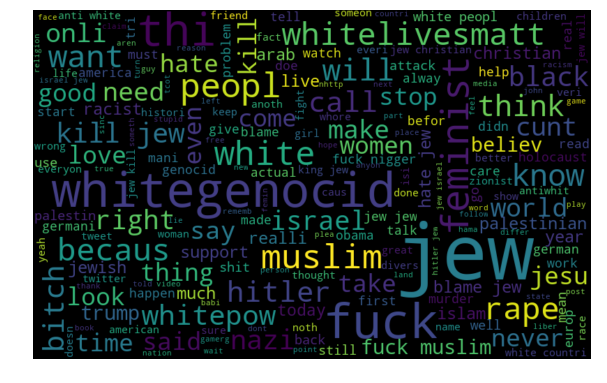

In [8]:
all_words = ' '.join([text for text in df['tidy_tweet']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [9]:
max_fatures = 500
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(df['tidy_tweet'].values)
X = tokenizer.texts_to_sequences(df['tidy_tweet'].values)
X = pad_sequences(X)

In [10]:
Y = pd.get_dummies(df['Label']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(16288, 26) (16288, 2)
(4072, 26) (4072, 2)


In [11]:
X_val = X_train[:4072]
Y_val = Y_train[:4072]

In [12]:
partial_X_train = X_train[4072:]
partial_Y_train = Y_train[4072:]

In [31]:
embed_dim = 64
lstm_out = 64

from keras.layers import Bidirectional,GRU, Activation

model = Sequential()

model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))

model.add(LSTM(128,return_sequences=True))
model.add(LSTM(128,return_sequences=True))
model.add(LSTM(128,return_sequences=True))
model.add(LSTM(64,return_sequences=True))
model.add(LSTM(64,return_sequences=True))
#model.add(Bidirectional(GRU(lstm_out, recurrent_dropout=0.2, dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(lstm_out, recurrent_dropout=0.2, dropout=0.2, return_sequences=True)))
#model.add(Bidirectional(GRU(lstm_out, recurrent_dropout=0.2, dropout=0.2, return_sequences=False)))
model.add(Bidirectional(LSTM(lstm_out, recurrent_dropout=0.2, dropout=0.2, return_sequences=False)))

model.add(Dense(2, activation='softsign',kernel_initializer='he_uniform'))
model.compile(loss = 'mean_squared_error', optimizer='Adagrad',metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 26, 64)            32000     
_________________________________________________________________
lstm_69 (LSTM)               (None, 26, 128)           98816     
_________________________________________________________________
lstm_70 (LSTM)               (None, 26, 128)           131584    
_________________________________________________________________
lstm_71 (LSTM)               (None, 26, 128)           131584    
_________________________________________________________________
lstm_72 (LSTM)               (None, 26, 64)            49408     
_________________________________________________________________
lstm_73 (LSTM)               (None, 26, 64)            33024     
_________________________________________________________________
bidirectional_21 (Bidirectio (None, 26, 128)           66048     
__________

In [32]:
batch_size = 128
history = model.fit(partial_X_train, 
                    partial_Y_train, 
                    epochs = 20, 
                    batch_size=batch_size, 
                    validation_data=(X_val, Y_val))

Train on 12216 samples, validate on 4072 samples
Epoch 1/20
12216/12216 [==============================] - 125s 10ms/step - loss: 0.2186 - acc: 0.7289 - val_loss: 0.1908 - val_acc: 0.7434
Epoch 2/20
12216/12216 [==============================] - 134s 11ms/step - loss: 0.1928 - acc: 0.7402 - val_loss: 0.1909 - val_acc: 0.7434
Epoch 3/20
12216/12216 [==============================] - 115s 9ms/step - loss: 0.1924 - acc: 0.7402 - val_loss: 0.1908 - val_acc: 0.7434
Epoch 4/20
12216/12216 [==============================] - 128s 10ms/step - loss: 0.1911 - acc: 0.7402 - val_loss: 0.1895 - val_acc: 0.7434
Epoch 5/20
12216/12216 [==============================] - 114s 9ms/step - loss: 0.1872 - acc: 0.7412 - val_loss: 0.1895 - val_acc: 0.7375
Epoch 6/20
12216/12216 [==============================] - 113s 9ms/step - loss: 0.1822 - acc: 0.7515 - val_loss: 0.1875 - val_acc: 0.7412
Epoch 7/20
12216/12216 [==============================] - 112s 9ms/step - loss: 0.1792 - acc: 0.7556 - val_loss: 0.1872 

In [33]:
loss, accuracy = model.evaluate(X_train,Y_train , verbose=False)
print("Training Accuracy: {:.2f}".format(accuracy))
loss, accuracy = model.evaluate(X_test,Y_test, verbose=False)
print("Testing Accuracy:  {:.2f}".format(accuracy))

Training Accuracy: 0.79
Testing Accuracy:  0.74
